# Estimating Optimal Gaussian Log Transform

Using maximum likelihood to estimate $\epsilon$ so that $\log(\tau + \epsilon)$ is gaussian. 

In [13]:
## Getting the data

from qc_c6 import QC_OCEAN, QC_LAND, QC_DEEP

aqua  = 'data/giant_C6_10km_Aqua_20151005.nc'
terra = 'data/giant_C6_10km_Terra_20150921.nc'

# Ingest Quality Controled Data
Albedo = ['CxAlbedo'] # surface characteristics
modo = QC_OCEAN(terra,Albedo=Albedo,verbose=True,
                cloud_thresh=0.80,
                glint_thresh=40.0,
                outliers=3.)

Outlier removal: -1   sig_d = 0.359961  nGood=44648 
Outlier removal: 0   sig_d = 0.294501  nGood=43515 
Outlier removal: 1   sig_d = 0.274378  nGood=42559 
Outlier removal: 2   sig_d = 0.265947  nGood=42051 


##  AOD Kernel Density Estimate


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import kde

tau = modo.aTau550
ref = modo.mRef870

bins, P = kde.calc_kde1d(tau,range=(0,1))


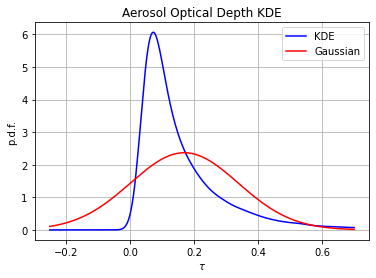

In [6]:

def plot_aod(tau,range=(-0.25,0.7),title='Aerosol Optical Depth KDE'):
    """
    Plot KDE of log transform
    """
    x = tau

    # KDE
    bins, P = kde.calc_kde1d(x,range=range)

    # Calculate corresponding Gaussian distribution
    mu = np.mean(x)
    sig = np.std(x)
    G = 1. /(sig * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sig**2) )
    
    # Plot KDE & Gaussian
    plt.plot(bins,P,'b',label='KDE')
    plt.plot(bins,G,'r',label='Gaussian')
    #plt.plot(bins,G*np.log(G/P),'k',label='KL Integrand')
    plt.grid()
    plt.legend()
    plt.xlabel(r'$\tau$')
    plt.ylabel('p.d.f.')
    plt.title(title)
    
plot_aod(tau)

## Canonical log transform ($\epsilon=0.01$)

In [4]:

def plot_laod(tau,eps=0.01,range=(-4,1)):
    """
    Plot KDE of log transform
    """
    x = np.log(tau+eps)

    # KDE
    bins, P = kde.calc_kde1d(x,range=range)

    # Calculate corresponding Gaussian distribution
    mu = np.mean(x)
    sig = np.std(x)
    G = 1. /(sig * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sig**2) )
    
    # Plot KDE & Gaussian
    plt.plot(bins,P,'b',label='KDE')
    plt.plot(bins,G,'r',label='Gaussian')
    plt.plot(bins,G*np.log(G/P),'k',label='KL Integrand')
    plt.grid()
    plt.legend()
    plt.xlabel(r'$\log(\tau+%f)$'%eps)
    plt.ylabel('p.d.f.')
    plt.title('Log-transformed Aerosol Optical Depth KDE')


## Estimating $\epsilon$

 
 
Given,

\begin{align}
x_n & =   \log(\tau_n + \epsilon) \\
\mu(\epsilon) &= {1\over N} \sum_{n=1}^N x_n \\
\sigma^2(\epsilon) &= {1\over N-1} \sum_{n=1}^N (x_n -\mu(\epsilon))^2\\
\end{align}

where $\tau$ is the aerosol optical depth, we estimate $\epsilon$ by minimizing the log-likelihood

$$
J(\epsilon) = \log\sigma^2(\epsilon) + {1 \over N} \sum_{n=1}^N { \left [ x_n - \mu(\epsilon) \right ]^2 \over \sigma^2(\epsilon) } =  \log\sigma^2(\epsilon) + {N-1\over N} \sim \log\sigma^2(\epsilon)
$$

This does not quite work.

Text(0.5, 1.0, 'Log-likelihood Loss Function')

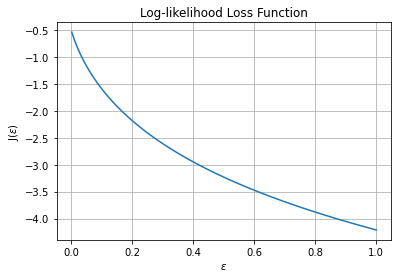

In [139]:
def loss(eps,tau):
    """
    Log-likelihood loss function.
    """
    x = np.log(tau+eps)
    mu = np.mean(x)
    sig2 = np.std(x)**2
    J = np.log(sig2) # + np.mean((x-mu)**2) / sig2
    return J
    
Eps = np.linspace(0.001,1.,100)
J = np.array([ loss(eps,tau) for eps in Eps])

plt.plot(Eps,J)
plt.grid()
plt.xlabel(r'$\epsilon$')
plt.ylabel('J($\epsilon$)')
plt.title('Log-likelihood Loss Function')



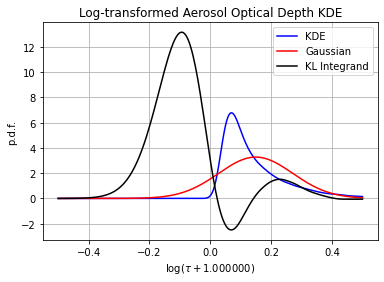

In [140]:
plot_laod(tau,eps=1,range=(-0.5,0.5))

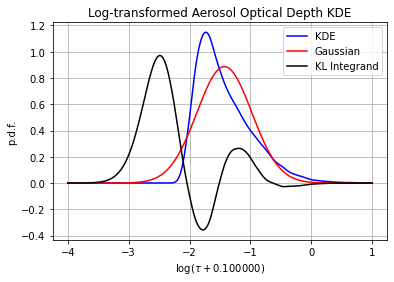

In [126]:
plot_laod(tau,eps=0.1)

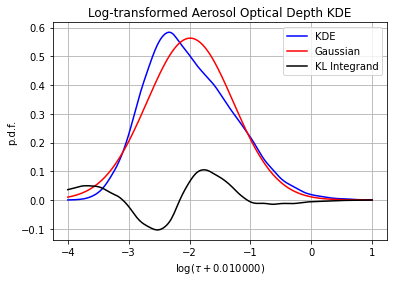

In [127]:
plot_laod(tau,eps=0.01)

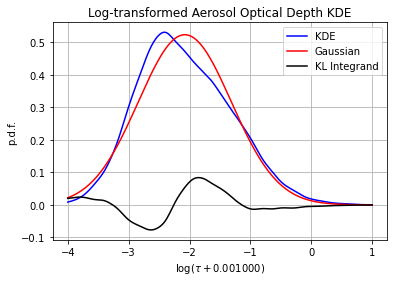

In [128]:
plot_laod(tau,eps=0.001)

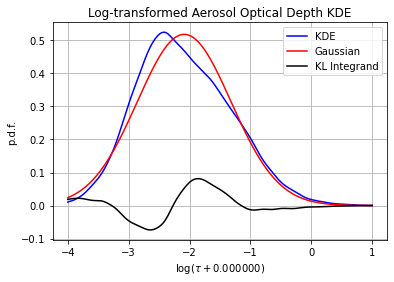

In [129]:
plot_laod(tau,eps=0)

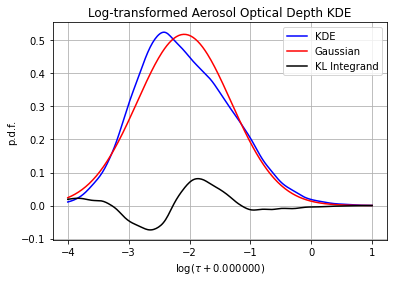

In [156]:
plot_laod(tau,eps=1e-7,range=(-4,1))

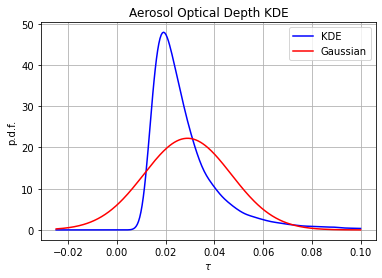

In [148]:
plot_aod(modo.mRef870,range=(-0.025,0.1))

## Scaling

Given the similar shape of the distributions of AOD and reflectances, let's come up with some convenient scaling. Start my normalizing by the mode of the distributions:


0.07450980392156863 0.019117647058823524


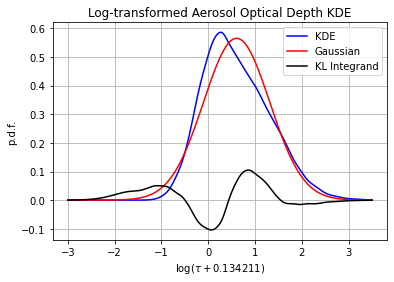

In [19]:
tbins, P = kde.calc_kde1d(tau,range=(0,1))
rbins, Q = kde.calc_kde1d(ref,range=(-0.025,0.1))

tau_m = tbins[P.argmax()]
ref_m = rbins[Q.argmax()]

print(tau_m,ref_m)

tau_ = tau / tau_m
ref_ = ref / ref_m

tbins, P_ = kde.calc_kde1d(tau_,range=(-1,10))
rbins, Q_ = kde.calc_kde1d(ref_,range=(-1,10))

#plt.plot(tbins,P_)
#plt.plot(rbins,Q_)
#plt.grid()

plot_laod(tau_,0.01/tau_m,range=(-3,3.5))


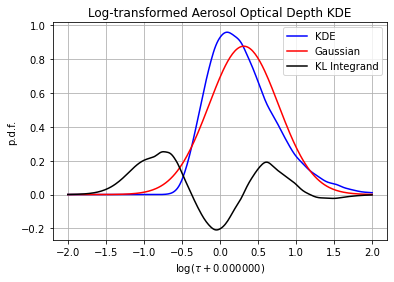

In [25]:
plot_laod(ref_,0,range=(-2,2))

## BoxCox Transform

In [28]:
import scipy.stats as stats

(tau_,p)=stats.boxcox(tau)

print(p,tau_.min(),tau_.max())


-0.1595074739561126 -7.0209336 1.2512959


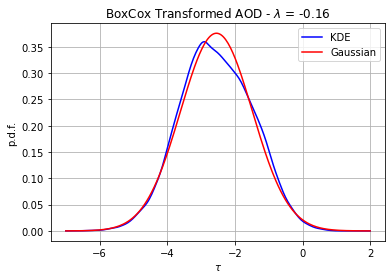

In [35]:
plot_aod(tau_,range=(-7,2),title=r'BoxCox Transformed AOD - $\lambda$ = %4.2f'%p)

In [37]:
(ref_,p)=stats.boxcox(ref)

print(p,ref_.min(),ref_.max())

-0.6755178803635112 -34.19013 -1.3112662


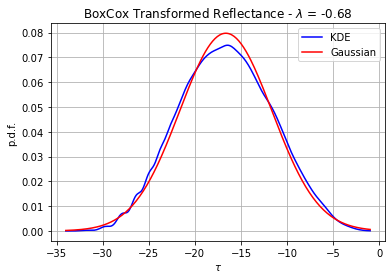

In [38]:
plot_aod(ref_,range=(-34,-1),title=r'BoxCox Transformed Reflectance - $\lambda$ = %4.2f'%p)